In [1]:
# Import the necessary libraries
import numpy as np
import pandas as pd
import os
import time
import warnings
import gc
gc.collect()
import os
from six.moves import urllib
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
warnings.filterwarnings('ignore')
%matplotlib inline
plt.style.use('seaborn')
from scipy import stats
from scipy.stats import norm, skew
from sklearn.preprocessing import StandardScaler

In [2]:
#Add All the Models Libraries
# preprocessing
from sklearn.preprocessing import LabelEncoder
label_enc = LabelEncoder()
# Scalers
from sklearn.utils import shuffle
from sklearn.pipeline import Pipeline
from sklearn.pipeline import FeatureUnion

# Models

from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_log_error,mean_squared_error, r2_score,mean_absolute_error

from sklearn.model_selection import train_test_split #training and testing data split
from sklearn import metrics #accuracy measure
from sklearn.metrics import confusion_matrix #for confusion matrix
from scipy.stats import reciprocal, uniform

from sklearn.model_selection import StratifiedKFold, RepeatedKFold

# Cross-validation
from sklearn.model_selection import KFold #for K-fold cross validation
from sklearn.model_selection import cross_val_score #score evaluation
from sklearn.model_selection import cross_val_predict #prediction
from sklearn.model_selection import cross_validate

# GridSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

In [3]:
# to make this notebook's output stable across runs
np.random.seed(123)
gc.collect()
# To plot pretty figures
%matplotlib inline
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

In [4]:
#Reduce the memory usage - by Panchajanya Banerjee
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

In [136]:
train = reduce_mem_usage(pd.read_csv('train.csv',parse_dates=["first_active_month"]))
test = reduce_mem_usage(pd.read_csv('test.csv', parse_dates=["first_active_month"]))

Mem. usage decreased to  4.04 Mb (56.2% reduction)
Mem. usage decreased to  2.24 Mb (52.5% reduction)


In [137]:
test.first_active_month = test.first_active_month.fillna(pd.to_datetime('2017-09-01'))
test.isnull().sum()

first_active_month    0
card_id               0
feature_1             0
feature_2             0
feature_3             0
dtype: int64

In [ ]:
reference = pd.read_csv('Cardreferencedate.csv')
train = pd.merge(train, reference, on='card_id',how='left')
test = pd.merge(test, reference, on='card_id',how='left')
train['days'] = (pd.to_datetime(train['reference_date']) - train['first_active_month']).dt.days
test['days'] = (pd.to_datetime(test['reference_date']) - test['first_active_month']).dt.days

In [7]:
# Taking Reference from Other Kernels
def aggregate_transaction_hist(trans, prefix):  
        
    agg_func = {
        'purchase_date' : ['max','min'],
        'month_diff' : ['mean', 'min', 'max', 'var'],
        'month_diff_lag' : ['mean', 'min', 'max', 'var'],
        'weekend' : ['sum', 'mean'],
        'authorized_flag': ['sum', 'mean'],
        'category_1': ['sum','mean', 'max','min'],
        'purchase_amount': ['sum', 'mean', 'max', 'min', 'std'],
        'installments': ['sum', 'mean', 'max', 'min', 'std'],  
        'month_lag': ['max','min','mean','var'],
        'card_id' : ['size'],
        'month': ['nunique'],
        'hour': ['nunique'],
        'weekofyear': ['nunique'],
        'dayofweek': ['nunique'],
        'year': ['nunique'],
        'subsector_id': ['nunique'],
        'merchant_category_id' : ['nunique', lambda x:stats.mode(x)[0]],
        'merchant_id' : ['nunique', lambda x:stats.mode(x)[0]],
        'state_id' : ['nunique', lambda x:stats.mode(x)[0]],
    }
    
    agg_trans = trans.groupby(['card_id']).agg(agg_func)
    agg_trans.columns = [prefix + '_'.join(col).strip() for col in agg_trans.columns.values]
    agg_trans.reset_index(inplace=True)
    
    df = (trans.groupby('card_id').size().reset_index(name='{}transactions_count'.format(prefix)))
    
    agg_trans = pd.merge(df, agg_trans, on='card_id', how='left')
    
    return agg_trans

In [9]:
transactions = reduce_mem_usage(pd.read_csv('historical_transactions_clean_outlier.csv'))
transactions = transactions.loc[transactions.purchase_amount < 100,]
transactions['authorized_flag'] = transactions['authorized_flag'].map({'Y': 1, 'N': 0})
transactions['category_1'] = transactions['category_1'].map({'Y': 0, 'N': 1})

Mem. usage decreased to 1638.06 Mb (50.8% reduction)


In [10]:
#Feature Engineering - Adding new features 
transactions['purchase_date'] = pd.to_datetime(transactions['purchase_date'])
transactions['year'] = transactions['purchase_date'].dt.year
transactions['weekofyear'] = transactions['purchase_date'].dt.weekofyear
transactions['month'] = transactions['purchase_date'].dt.month
transactions['dayofweek'] = transactions['purchase_date'].dt.dayofweek
transactions['weekend'] = (transactions.purchase_date.dt.weekday >=5).astype(int)
transactions['hour'] = transactions['purchase_date'].dt.hour 
transactions['quarter'] = transactions['purchase_date'].dt.quarter
transactions['month_diff'] = ((pd.to_datetime('01/03/2018') - transactions['purchase_date']).dt.days)//30
transactions['month_diff_lag'] = transactions['month_diff'] + transactions['month_lag']

gc.collect()

151

In [ ]:
success = transactions.loc[transactions['authorized_flag'] == 1][['card_id', 'city_id','installments', 
                                                                  'merchant_category_id', 'merchant_id', 
                                                                  'purchase_amount', ]]

gc.collect()

In [ ]:
def aggregate_success(trans, prefix):  
        
    agg_func = {
        'purchase_amount': ['sum', 'mean'],
        'installments': ['sum', 'mean'],  
        'merchant_category_id' : ['nunique'],
        'merchant_id' : ['nunique'],
    }
    
    agg_trans = trans.groupby(['card_id']).agg(agg_func)
    agg_trans.columns = [prefix + '_'.join(col).strip() for col in agg_trans.columns.values]
    agg_trans.reset_index(inplace=True)
    
    df = (trans.groupby('card_id').size().reset_index(name='{}transactions_count'.format(prefix)))
    
    agg_trans = pd.merge(df, agg_trans, on='card_id', how='left')
    
    return agg_trans

merge_success = aggregate_success(success, prefix='success_')
del success

train = pd.merge(train, merge_success, on='card_id',how='left')
test = pd.merge(test, merge_success, on='card_id',how='left')
gc.collect()

In [11]:
def aggregate_bymonth(trans, prefix):  
        
    agg_func = {
        'purchase_amount': ['sum', 'mean'],
        'card_id' : ['size'],
        'merchant_category_id' : ['nunique', lambda x:stats.mode(x)[0]],
#        'merchant_id' : ['nunique', lambda x:stats.mode(x)[0]],
    }
    
    agg_trans = trans.groupby(['card_id','month','year']).agg(agg_func)
    agg_trans.columns = [prefix + '_'.join(col).strip() for col in agg_trans.columns.values]
    agg_trans.reset_index(inplace=True)
    
    df = (trans.groupby('card_id').size().reset_index(name='{}transactions_count'.format(prefix)))
    
    agg_trans = pd.merge(df, agg_trans, on='card_id', how='left')
    
    return agg_trans

merge = aggregate_bymonth(transactions, prefix='hist_')
merge = merge.drop(['hist_transactions_count'], axis = 1)
merge['Date'] = pd.to_datetime(merge[['year', 'month']].assign(Day=1))

In [138]:
# df1 = merge.groupby(['card_id', 'hist_merchant_category_id_<lambda>']).size().reset_index(name='Count')
# df1 = df1.loc[df1.Count > 1]
# df1 = df1.groupby(['card_id']).agg({'Count':['sum']})
# df1.columns = ['category_repeated_month']

train = pd.merge(train, df1, on='card_id',how='left')
test = pd.merge(test, df1, on='card_id',how='left')
gc.collect()

435

In [139]:
## Second last month
# amerge = merge.sort_values('Date').groupby('card_id', 
#                                            as_index=False).apply(lambda x: x.iloc[-2])[['card_id','hist_card_id_size','hist_purchase_amount_sum','hist_purchase_amount_mean']]
# new_names = [(i,i+'_last2') for i in amerge.iloc[:, 1:].columns.values]
# amerge.rename(columns = dict(new_names), inplace=True)

train = pd.merge(train, amerge, on='card_id',how='left')
test = pd.merge(test, amerge, on='card_id',how='left')

gc.collect()

42

In [140]:
# # last month and first month
# merge1 = merge.loc[merge.groupby('card_id').Date.idxmax(),:][[ 'card_id','hist_card_id_size',
#                                                           'hist_purchase_amount_sum','hist_purchase_amount_mean','hist_merchant_category_id_nunique']]
# new_names = [(i,i+'_last') for i in merge1.iloc[:, 1:].columns.values]
# merge1.rename(columns = dict(new_names), inplace=True)

# merge2 = merge.loc[merge.groupby('card_id').Date.idxmin(),:][['card_id','hist_card_id_size',
#                                                           'hist_purchase_amount_sum','hist_purchase_amount_mean','hist_merchant_category_id_nunique']]
# new_names = [(i,i+'_first') for i in merge2.iloc[:, 1:].columns.values]
# merge2.rename(columns = dict(new_names), inplace=True)
# comb = pd.merge(merge1, merge2, on='card_id',how='left')

train = pd.merge(train, comb, on='card_id',how='left')
test = pd.merge(test, comb, on='card_id',how='left')

gc.collect()

42

In [141]:
## Same merchant purchase
# df2 = (transactions.groupby(['card_id','merchant_id','purchase_amount']).size().reset_index(name='count_hist'))
# df2['purchase_amount_hist'] = df2.groupby(['card_id','merchant_id'])['purchase_amount'].transform('sum')
# df2['count_hist'] = df2.groupby(['card_id','merchant_id'])['count_hist'].transform('sum')
# df2 = df2.drop_duplicates()
# df2 = df2.loc[df2['count_hist'] >= 2]
# agg_func = {
#     'count_hist' : ['count'],
#     'purchase_amount_hist':['sum','mean'],
#     'purchase_amount':['sum','mean'],
# }
# df2 = df2.groupby(['card_id']).agg(agg_func)
# df2.columns = [''.join(col).strip() for col in df2.columns.values]
# new_names = [(i,i+'_merhist') for i in df2.iloc[:, 3:].columns.values]
# df2.rename(columns = dict(new_names), inplace=True)

train = pd.merge(train, df2, on='card_id',how='left')
test = pd.merge(test, df2, on='card_id',how='left')

In [142]:
# # Same category purchase
# df3 = (transactions.groupby(['card_id','merchant_category_id','purchase_amount']).size().reset_index(name='hist_count'))
# df3['hist_purchase_amount'] = df3.groupby(['card_id','merchant_category_id'])['purchase_amount'].transform('sum')
# df3['hist_count'] = df3.groupby(['card_id','merchant_category_id'])['hist_count'].transform('sum')
# df3 = df3.drop_duplicates()
# df3 = df3.loc[df3['hist_count'] >= 2]
# df3['hist_count_4'] = 0
# df3.loc[df3['hist_count'] >= 4, 'hist_count_4'] = 1
# df3['hist_mean4'] = 0
# df3.loc[df3['hist_count'] >= 4, 'hist_mean4'] = df3['hist_purchase_amount']/df3['hist_count']
# agg_fun = {
#     'hist_count' : ['count'],
#     'hist_count_4' : ['sum'],
#     'hist_purchase_amount':['sum','mean'],
#     'hist_mean4' : ['sum','mean'],
#     'purchase_amount':['sum','mean'],
# }
# df3 = df3.groupby(['card_id']).agg(agg_fun)
# df3.columns = [''.join(col).strip() for col in df3.columns.values]
# new_names = [(i,'hist'+i) for i in df3.iloc[:, 6:].columns.values]
# df3.rename(columns = dict(new_names), inplace=True)

train = pd.merge(train, df3, on='card_id',how='left')
test = pd.merge(test, df3, on='card_id',how='left')

In [16]:
merchants = reduce_mem_usage(pd.read_csv('merchants_clean.csv'))
merchants = merchants.drop(['Unnamed: 0', 'merchant_group_id', 'merchant_category_id',
                            'subsector_id', 'numerical_1', 'numerical_2', 
                            'active_months_lag3','active_months_lag6',
                            'city_id', 'state_id'], axis = 1)
d = dict(zip(merchants.columns[1:], ['histchant_{}'.format(x) for x in (merchants.columns[1:])]))
d.update({"merchant_id": "hist_merchant_id_<lambda>"})
merchants = merchants.rename(index=str, columns= d)
## convert the month in business to categorical
merchants.histchant_active_months_lag12 = pd.cut(merchants.histchant_active_months_lag12, 4)

gc.collect()

Mem. usage decreased to 16.91 Mb (71.2% reduction)


49

In [103]:
merge_trans = aggregate_transaction_hist(transactions, prefix='hist_')
merge_trans = merge_trans.merge(merchants, on = 'hist_merchant_id_<lambda>', how = 'left')
## hist transaction frequency
merge_trans['hist_freq'] = merge_trans.hist_transactions_count/(((merge_trans.hist_purchase_date_max - 
                                                         merge_trans.hist_purchase_date_min).dt.total_seconds())/86400)
merge_trans['hist_freq_amount'] = merge_trans['hist_freq'] * merge_trans['hist_purchase_amount_mean']
merge_trans['hist_freq_install'] = merge_trans['hist_freq'] * merge_trans['hist_installments_mean']

gc.collect()

30353

In [18]:
cols = ['histchant_avg_sales_lag3','histchant_avg_purchases_lag3',
        'histchant_avg_sales_lag6','histchant_avg_purchases_lag6',
        'histchant_avg_sales_lag12','histchant_avg_purchases_lag12','hist_freq']
for col in cols:
    merge_trans[col] = pd.qcut(merge_trans[col], 4)

In [19]:
for col in cols:
    merge_trans[col].fillna(merge_trans[col].mode()[0], inplace=True)
    label_enc.fit(list(merge_trans[col].values)) 
    merge_trans[col] = label_enc.transform(list(merge_trans[col].values))

In [20]:
for col in ['histchant_category_1','histchant_most_recent_sales_range','histchant_most_recent_purchases_range',
           'histchant_active_months_lag12','histchant_category_4','histchant_category_2']:
    merge_trans[col].fillna(merge_trans[col].mode()[0], inplace=True)

In [21]:
label_enc.fit(list(merge_trans['hist_merchant_id_<lambda>'].values)) 
merge_trans['hist_merchant_id_<lambda>'] = label_enc.transform(list(merge_trans['hist_merchant_id_<lambda>'].values))
label_enc.fit(list(merge_trans['histchant_active_months_lag12'].values)) 
merge_trans['histchant_active_months_lag12'] = label_enc.transform(list(merge_trans['histchant_active_months_lag12'].values))

In [143]:
#del transactions
gc.collect()
train = pd.merge(train, merge_trans, on='card_id',how='left')
test = pd.merge(test, merge_trans, on='card_id',how='left')
#del merge_trans
gc.collect()

28

In [ ]:
# a = transactions.groupby('merchant_category_id').agg({'purchase_amount':['sum','mean']})
# a.columns = ['merchanthist' + '_'.join(col).strip() for col in a.columns.values]
# b = (transactions.groupby(['card_id','merchant_category_id','purchase_amount']).size().reset_index(name='hist_count'))
# b = b.groupby(['card_id','merchant_category_id']).agg({'purchase_amount':['sum','mean'],'hist_count':['sum']})
# b.columns = [''.join(col).strip() for col in b.columns.values]
# b = b.loc[b.groupby('card_id')['hist_countsum'].idxmax()]
# b = b.join(a, on='merchant_category_id',how='left')
# b['merchant_ratio_sum'] = b['purchase_amountsum']/b['merchanthistpurchase_amount_sum']
# b['merchant_ratio_mean'] = b['purchase_amountmean']/b['merchanthistpurchase_amount_mean']
# b = b.reset_index()
# b = b.drop(['merchant_category_id','merchanthistpurchase_amount_sum','merchanthistpurchase_amount_mean'], axis = 1)


# train = pd.merge(train, b, on='card_id',how='left')
# test = pd.merge(test, b, on='card_id',how='left')

In [144]:
#Feature Engineering - Adding new features 
train['hist_purchase_date_max'] = pd.to_datetime(train['hist_purchase_date_max'])
train['hist_purchase_date_min'] = pd.to_datetime(train['hist_purchase_date_min'])
train['hist_purchase_date_diff'] = (train['hist_purchase_date_max'] - train['hist_purchase_date_min']).dt.days
train['hist_purchase_date_average'] = train['hist_purchase_date_diff']/train['hist_card_id_size']
train['hist_purchase_date_uptonow'] = (pd.to_datetime('01/03/2018') - train['hist_purchase_date_max']).dt.days
train['hist_purchase_date_uptomin'] = (pd.to_datetime('01/03/2018') - train['hist_purchase_date_min']).dt.days
train['hist_first_buy'] = (train['hist_purchase_date_min'] - train['first_active_month']).dt.days
for feature in ['hist_purchase_date_max','hist_purchase_date_min']:
    train[feature] = train[feature].astype(np.int64) * 1e-9
gc.collect()

65

In [145]:
#Feature Engineering - Adding new features 
test['hist_purchase_date_max'] = pd.to_datetime(test['hist_purchase_date_max'])
test['hist_purchase_date_min'] = pd.to_datetime(test['hist_purchase_date_min'])
test['hist_purchase_date_diff'] = (test['hist_purchase_date_max'] - test['hist_purchase_date_min']).dt.days
test['hist_purchase_date_average'] = test['hist_purchase_date_diff']/test['hist_card_id_size']
test['hist_purchase_date_uptonow'] = (pd.to_datetime('01/03/2018') - test['hist_purchase_date_max']).dt.days
test['hist_purchase_date_uptomin'] = (pd.to_datetime('01/03/2018') - test['hist_purchase_date_min']).dt.days
test['hist_first_buy'] = (test['hist_purchase_date_min'] - test['first_active_month']).dt.days
for feature in ['hist_purchase_date_max','hist_purchase_date_min']:
    test[feature] = test[feature].astype(np.int64) * 1e-9

gc.collect()

75

In [25]:
# Taking Reference from Other Kernels
def aggregate_transaction_new(trans, prefix):  
        
    agg_func = {
        'purchase_date' : ['max','min'],
        'month_diff' : ['mean', 'min', 'max'],
        'month_diff_lag' : ['mean', 'min', 'max'],
        'weekend' : ['sum', 'mean'],
        'category_1': ['sum','mean', 'max','min'],
        'purchase_amount': ['sum', 'mean', 'max', 'min'],
        'installments': ['sum', 'mean', 'max', 'min'],  
        'month_lag': ['max','min','mean'],
        'card_id' : ['size'],
        'month': ['nunique'],
        'hour': ['nunique'],
        'weekofyear': ['nunique'],
        'dayofweek': ['nunique'],
        'year': ['nunique'],
        'subsector_id': ['nunique'],
        'merchant_category_id' : ['nunique', lambda x:stats.mode(x)[0]],
        'merchant_id' : ['nunique', lambda x:stats.mode(x)[0]],
        'state_id' : ['nunique', lambda x:stats.mode(x)[0]],
    }
    
    agg_trans = trans.groupby(['card_id']).agg(agg_func)
    agg_trans.columns = [prefix + '_'.join(col).strip() for col in agg_trans.columns.values]
    agg_trans.reset_index(inplace=True)
    
    df = (trans.groupby('card_id').size().reset_index(name='{}transactions_count'.format(prefix)))
    
    agg_trans = pd.merge(df, agg_trans, on='card_id', how='left')
    
    return agg_trans

In [26]:
# Now extract the data from the new transactions
new_transactions = reduce_mem_usage(pd.read_csv('new_merchant_transactions_clean_outlier.csv'))
new_transactions = new_transactions.loc[new_transactions.purchase_amount < 100,]
new_transactions['authorized_flag'] = new_transactions['authorized_flag'].map({'Y': 1, 'N': 0})
new_transactions['category_1'] = new_transactions['category_1'].map({'Y': 0, 'N': 1})

Mem. usage decreased to 106.71 Mb (52.5% reduction)


In [27]:
#Feature Engineering - Adding new features inspired by Chau's first kernel
new_transactions['purchase_date'] = pd.to_datetime(new_transactions['purchase_date'])
new_transactions['year'] = new_transactions['purchase_date'].dt.year
new_transactions['weekofyear'] = new_transactions['purchase_date'].dt.weekofyear
new_transactions['month'] = new_transactions['purchase_date'].dt.month
new_transactions['dayofweek'] = new_transactions['purchase_date'].dt.dayofweek
new_transactions['weekend'] = (new_transactions.purchase_date.dt.weekday >=5).astype(int)
new_transactions['hour'] = new_transactions['purchase_date'].dt.hour 
new_transactions['quarter'] = new_transactions['purchase_date'].dt.quarter
new_transactions['is_month_start'] = new_transactions['purchase_date'].dt.is_month_start
new_transactions['month_diff'] = ((pd.to_datetime('01/03/2018') - new_transactions['purchase_date']).dt.days)//30
new_transactions['month_diff_lag'] = new_transactions['month_diff'] + new_transactions['month_lag']

gc.collect()

# new_transactions['Christmas_Day_2017'] = (pd.to_datetime('2017-12-25') - 
#                                           new_transactions['purchase_date']).dt.days.apply(lambda x: x if x > 0 and x <= 15 else 0)
# new_transactions['Valentine_Day_2017'] = (pd.to_datetime('2017-06-13') - 
#                                           new_transactions['purchase_date']).dt.days.apply(lambda x: x if x > 0 and x <= 7 else 0)
# #Black Friday : 24th November 2017
# new_transactions['Black_Friday_2017'] = (pd.to_datetime('2017-11-27') - 
#                                          new_transactions['purchase_date']).dt.days.apply(lambda x: x if x > 0 and x <= 7 else 0)

140

In [28]:
new_merge = aggregate_bymonth(new_transactions, prefix='new_')
new_merge = new_merge.drop(['new_transactions_count'], axis = 1)
new_merge['Date'] = pd.to_datetime(new_merge[['year', 'month']].assign(Day=1))

gc.collect()

49

In [146]:
# new_merge1 = new_merge.loc[new_merge.groupby('card_id').Date.idxmax(),:][[ 'card_id','new_card_id_size',
#                                                           'new_purchase_amount_sum','new_purchase_amount_mean']]
# new_names = [(i,i+'_last') for i in new_merge1.iloc[:, 1:].columns.values]
# new_merge1.rename(columns = dict(new_names), inplace=True)

# new_merge2 = new_merge.loc[new_merge.groupby('card_id').Date.idxmin(),:][['card_id','new_card_id_size',
#                                                           'new_purchase_amount_sum','new_purchase_amount_mean']]
# new_names = [(i,i+'_first') for i in new_merge2.iloc[:, 1:].columns.values]
# new_merge2.rename(columns = dict(new_names), inplace=True)
# new_comb = pd.merge(new_merge1, new_merge2, on='card_id',how='left')

train = pd.merge(train, new_merge1, on='card_id',how='left')
test = pd.merge(test, new_merge1, on='card_id',how='left')

gc.collect()

28

In [147]:
## Same merchant purchase
df = (new_transactions.groupby(['card_id','merchant_id','purchase_amount']).size().reset_index(name='count_new'))
df['purchase_amount_new'] = df.groupby(['card_id','merchant_id'])['purchase_amount'].transform('sum')
df['count_new'] = df.groupby(['card_id','merchant_id'])['count_new'].transform('sum')
df = df.drop_duplicates()
df = df.loc[df['count_new'] >= 2]
agg_func = {
    'count_new' : ['count'],
    'purchase_amount_new':['sum','mean'],
    'purchase_amount':['sum','mean'],
}
df = df.groupby(['card_id']).agg(agg_func)
df.columns = [''.join(col).strip() for col in df.columns.values]
new_names = [(i,'new'+i) for i in df.iloc[:, 3:].columns.values]
df.rename(columns = dict(new_names), inplace=True)

train = pd.merge(train, df, on='card_id',how='left')
test = pd.merge(test, df, on='card_id',how='left')

In [148]:
# Same category purchase
df = (new_transactions.groupby(['card_id','merchant_category_id','purchase_amount']).size().reset_index(name='new_count'))
df['new_count'] = df.groupby(['card_id','merchant_category_id'])['new_count'].transform('sum')
df = df.drop_duplicates()
df = df.loc[df['new_count'] >= 2]
df['new_count_4'] = 0
df.loc[df['new_count'] >= 4, 'new_count_4'] = 1
agg_fun = {
    'new_count' : ['count'],
    'new_count_4' : ['sum'],
    'purchase_amount':['sum','mean'],
}
df = df.groupby(['card_id']).agg(agg_fun)
df.columns = ['a'.join(col).strip() for col in df.columns.values]

train = pd.merge(train, df, on='card_id',how='left')
test = pd.merge(test, df, on='card_id',how='left')

gc.collect()

35

In [32]:
merchants = reduce_mem_usage(pd.read_csv('merchants_clean.csv'))
merchants = merchants.drop(['Unnamed: 0', 'merchant_group_id', 'merchant_category_id',
                            'subsector_id', 'numerical_1', 'numerical_2', 
                            'active_months_lag3','active_months_lag6',
                            'city_id', 'state_id',
                           ], axis = 1)
d = dict(zip(merchants.columns[1:], ['newchant_{}'.format(x) for x in (merchants.columns[1:])]))
d.update({"merchant_id": "new_merchant_id_<lambda>"})
merchants = merchants.rename(index=str, columns= d)
## convert the month in business to categorical
merchants.newchant_active_months_lag12 = pd.cut(merchants.newchant_active_months_lag12, 4)

Mem. usage decreased to 16.91 Mb (71.2% reduction)


In [33]:
merge_new = aggregate_transaction_new(new_transactions, prefix='new_')
merge_new = merge_new.merge(merchants, on = 'new_merchant_id_<lambda>', how = 'left')
## new transaction frequency
merge_new['new_freq'] = merge_new.new_transactions_count/(((merge_new.new_purchase_date_max - 
                                                         merge_new.new_purchase_date_min).dt.total_seconds())/86400)
merge_new['new_freq_amount'] = merge_new['new_freq'] * merge_new['new_purchase_amount_mean']

In [34]:
cols = ['newchant_avg_sales_lag3','newchant_avg_purchases_lag3',
        'newchant_avg_sales_lag6','newchant_avg_purchases_lag6',
        'newchant_avg_sales_lag12','newchant_avg_purchases_lag12','new_freq']
for col in cols:
    merge_new[col] = pd.qcut(merge_new[col], 4)

In [35]:
for col in cols:
    merge_new[col].fillna(merge_new[col].mode()[0], inplace=True)
    label_enc.fit(list(merge_new[col].values)) 
    merge_new[col] = label_enc.transform(list(merge_new[col].values))

In [36]:
for col in ['newchant_category_1','newchant_most_recent_sales_range','newchant_most_recent_purchases_range',
           'newchant_active_months_lag12','newchant_category_4','newchant_category_2']:
    merge_new[col].fillna(merge_new[col].mode()[0], inplace=True)

In [37]:
label_enc.fit(list(merge_new['new_merchant_id_<lambda>'].values)) 
merge_new['new_merchant_id_<lambda>'] = label_enc.transform(list(merge_new['new_merchant_id_<lambda>'].values))
label_enc.fit(list(merge_new['newchant_active_months_lag12'].values)) 
merge_new['newchant_active_months_lag12'] = label_enc.transform(list(merge_new['newchant_active_months_lag12'].values))

In [149]:
#del new_transactions
gc.collect()

train = pd.merge(train, merge_new, on='card_id',how='left')
test = pd.merge(test, merge_new, on='card_id',how='left')
#del merge_new

gc.collect()

14

In [162]:
train_na = train.isnull().sum()
train_na = train_na.drop(train_na[train_na == 0].index).sort_values(ascending=False)
missing_data = pd.DataFrame({'Missing Value' :train_na})
missing_data.head(5)

,Missing Value


In [150]:
for col in ['new_freq','new_purchase_amount_min','new_purchase_amount_max','newchant_category_4','new_weekend_mean',
            'new_purchase_amount_mean','newchant_active_months_lag12','new_weekend_sum','newchant_avg_purchases_lag12',
            'newchant_avg_sales_lag12','newchant_avg_purchases_lag6','newchant_avg_sales_lag6','new_category_1_sum',
            'newchant_avg_purchases_lag3','newchant_avg_sales_lag3','new_category_1_mean','new_category_1_max',
            'new_category_1_min','newchant_most_recent_purchases_range','newchant_most_recent_sales_range',
            'newchant_category_1'] :     # -1
    train[col] = train[col].fillna(-1)
    test[col] = test[col].fillna(-1)
    
for col in ['new_installments_min','new_installments_max','new_installments_mean','new_installments_sum',
            'new_purchase_amount_sum','new_state_id_<lambda>' ]:      # -2
    train[col] = train[col].fillna(-2)
    test[col] = test[col].fillna(-2)
    
for col in ['newchant_category_2','new_month_lag_min','new_month_lag_max','new_card_id_size',
            'new_month_lag_mean','new_weekofyear_nunique','new_year_nunique','new_state_id_nunique',
            'new_merchant_id_<lambda>','new_merchant_id_nunique','new_merchant_category_id_nunique',
            'new_subsector_id_nunique','new_dayofweek_nunique','new_hour_nunique','new_month_nunique',
            'new_transactions_count','new_count_4asum','new_countacount','hist_count_4sum','hist_countcount',
            'hist_purchase_amountmean','hist_purchase_amountsum','purchase_amount_newmean','purchase_amount_newsum',
            'count_newcount','purchase_amount_histmean','purchase_amount_histsum','count_histcount','hist_mean4mean',
            'hist_mean4sum','newpurchase_amountmean','newpurchase_amountsum','purchase_amountmean_merhist',
            'purchase_amountsum_merhist','histpurchase_amountmean','histpurchase_amountsum',
            'new_merchant_category_id_<lambda>','category_repeated_month','new_purchase_amount_mean_last',
            'new_purchase_amount_sum_last','new_card_id_size_last','purchase_amountamean','purchase_amountasum']:      # 0
    train[col] = train[col].fillna(0)
    test[col] = test[col].fillna(0)
    
train.new_month_diff_mean = train.new_month_diff_mean.fillna(23)
train.new_month_diff_min = train.new_month_diff_min.fillna(23)
train.new_month_diff_max = train.new_month_diff_max.fillna(24)
train.new_month_diff_lag_mean = train.new_month_diff_lag_mean.fillna(24)
train.new_month_diff_lag_min = train.new_month_diff_lag_min.fillna(24)
train.new_month_diff_lag_max = train.new_month_diff_lag_max.fillna(24)

test.new_month_diff_mean = test.new_month_diff_mean.fillna(23)
test.new_month_diff_min = test.new_month_diff_min.fillna(23)
test.new_month_diff_max = test.new_month_diff_max.fillna(24)
test.new_month_diff_lag_mean = test.new_month_diff_lag_mean.fillna(24)
test.new_month_diff_lag_min = test.new_month_diff_lag_min.fillna(24)
test.new_month_diff_lag_max = test.new_month_diff_lag_max.fillna(24)

gc.collect()

0

In [151]:
for col in ['new_purchase_date_min','new_purchase_date_max']:
    train[col] = train[col].fillna(pd.to_datetime(1/9/2017))
    test[col] = test[col].fillna(pd.to_datetime(1/9/2017))

In [152]:
#Feature Engineering - Adding new features inspired by Chau's first kernel
train['total_count_merid'] = train['count_newcount'] + train['count_histcount']
train['total_count'] = train['new_countacount'] + train['hist_countcount']
train['new_purchase_date_max'] = pd.to_datetime(train['new_purchase_date_max'])
train['new_purchase_date_min'] = pd.to_datetime(train['new_purchase_date_min'])
train['new_purchase_date_diff'] = (train['new_purchase_date_max'] - train['new_purchase_date_min']).dt.days
train['new_purchase_date_average'] = train['new_purchase_date_diff']/train['new_card_id_size']
train['new_purchase_date_uptonow'] = (pd.to_datetime('01/03/2018') - train['new_purchase_date_max']).dt.days
train['new_purchase_date_uptomin'] = (pd.to_datetime('01/03/2018') - train['new_purchase_date_min']).dt.days
train['new_first_buy'] = (train['new_purchase_date_min'] - train['first_active_month']).dt.days
for feature in ['new_purchase_date_max','new_purchase_date_min']:
    train[feature] = train[feature].astype(np.int64) * 1e-9

#Feature Engineering - Adding new features inspired by Chau's first kernel
test['total_count_merid'] = test['count_newcount'] + test['count_histcount']
test['total_count'] = test['new_countacount'] + test['hist_countcount']
test['new_purchase_date_max'] = pd.to_datetime(test['new_purchase_date_max'])
test['new_purchase_date_min'] = pd.to_datetime(test['new_purchase_date_min'])
test['new_purchase_date_diff'] = (test['new_purchase_date_max'] - test['new_purchase_date_min']).dt.days
test['new_purchase_date_average'] = test['new_purchase_date_diff']/test['new_card_id_size']
test['new_purchase_date_uptonow'] = (pd.to_datetime('01/03/2018') - test['new_purchase_date_max']).dt.days
test['new_purchase_date_uptomin'] = (pd.to_datetime('01/03/2018') - test['new_purchase_date_min']).dt.days
test['new_first_buy'] = (test['new_purchase_date_min'] - test['first_active_month']).dt.days
for feature in ['new_purchase_date_max','new_purchase_date_min']:
    test[feature] = test[feature].astype(np.int64) * 1e-9
    
#added new feature - Interactive
train['card_id_total'] = train['new_card_id_size'] + train['hist_card_id_size']
train['purchase_amount_total'] = train['new_purchase_amount_sum'] + train['hist_purchase_amount_sum']

test['card_id_total'] = test['new_card_id_size'] + test['hist_card_id_size']
test['purchase_amount_total'] = test['new_purchase_amount_sum'] + test['hist_purchase_amount_sum']

gc.collect()

206

In [153]:
cols = ['new_freq_amount']
for col in cols:
    train[col] = train[col].fillna(0)
    train[col] = pd.qcut(train[col], 5)
    label_enc.fit(list(train[col].values)) 
    train[col] = label_enc.transform(list(train[col].values))
    
    test[col] = test[col].fillna(0)
    test[col] = pd.qcut(test[col], 5)
    label_enc.fit(list(test[col].values)) 
    test[col] = label_enc.transform(list(test[col].values))


In [154]:
train.new_purchase_date_average = train.new_purchase_date_average.fillna(-1.0)
test.new_purchase_date_average = test.new_purchase_date_average.fillna(-1.0)

In [155]:
# last month of new over hist 
train['amountmean_ratiolastnew'] = train.new_purchase_amount_mean_last/train.hist_purchase_amount_mean
train['amountsum_ratiolastnew'] = train.new_purchase_amount_sum_last/(train.hist_purchase_amount_sum/(train.hist_purchase_date_diff//30))
train['transcount_ratiolastnew'] = train.new_card_id_size_last/(train.hist_transactions_count/(train.hist_purchase_date_diff//30))

test['amountmean_ratiolastnew'] = test.new_purchase_amount_mean_last/test.hist_purchase_amount_mean
test['amountsum_ratiolastnew'] = test.new_purchase_amount_sum_last/(test.hist_purchase_amount_sum/(test.hist_purchase_date_diff//30))
test['transcount_ratiolastnew'] = test.new_card_id_size_last/(test.hist_transactions_count/(test.hist_purchase_date_diff//30))

In [156]:
# last month of hist over hist 
train['amountmean_ratiolast'] = train.hist_purchase_amount_mean_last/train.hist_purchase_amount_mean
train['amountsum_ratiolast'] = train.hist_purchase_amount_sum_last/(train.hist_purchase_amount_sum/(train.hist_purchase_date_diff//30))
train['transcount_ratiolast'] = train.hist_card_id_size_last/(train.hist_transactions_count/(train.hist_purchase_date_diff//30))

test['amountmean_ratiolast'] = test.hist_purchase_amount_mean_last/test.hist_purchase_amount_mean
test['amountsum_ratiolast'] = test.hist_purchase_amount_sum_last/(test.hist_purchase_amount_sum/(test.hist_purchase_date_diff//30))
test['transcount_ratiolast'] = test.hist_card_id_size_last/(test.hist_transactions_count/(test.hist_purchase_date_diff//30))

In [157]:
train['amountmean_ratiolast2'] = train.hist_purchase_amount_mean_last2/train.hist_purchase_amount_mean
train['amountsum_ratiolast2'] = train.hist_purchase_amount_sum_last2/(train.hist_purchase_amount_sum/(train.hist_purchase_date_diff//30))
train['transcount_ratiolast2'] = train.hist_card_id_size_last2/(train.hist_transactions_count/(train.hist_purchase_date_diff//30))

test['amountmean_ratiolast2'] = test.hist_purchase_amount_mean_last2/test.hist_purchase_amount_mean
test['amountsum_ratiolast2'] = test.hist_purchase_amount_sum_last2/(test.hist_purchase_amount_sum/(test.hist_purchase_date_diff//30))
test['transcount_ratiolast2'] = test.hist_card_id_size_last2/(test.hist_transactions_count/(test.hist_purchase_date_diff//30))

In [158]:
# last 2 month of hist ratio
train['amountmean_lastlast2'] = train.hist_purchase_amount_mean_last/train.hist_purchase_amount_mean_last2
train['amountsum_lastlast2'] = train.hist_purchase_amount_sum_last/train.hist_purchase_amount_sum_last2
train['transcount_lastlast2'] = train.hist_card_id_size_last/train.hist_card_id_size_last2

test['amountmean_lastlast2'] = test.hist_purchase_amount_mean_last/test.hist_purchase_amount_mean_last2
test['amountsum_lastlast2'] = test.hist_purchase_amount_sum_last/test.hist_purchase_amount_sum_last2
test['transcount_lastlast2'] =  test.hist_card_id_size_last/test.hist_card_id_size_last2

In [159]:
train = train.drop(['hist_purchase_amount_mean_last2','hist_purchase_amount_sum_last2','hist_card_id_size_last2',], axis = 1)
test = test.drop(['hist_purchase_amount_mean_last2','hist_purchase_amount_sum_last2','hist_card_id_size_last2',], axis = 1)

In [160]:
train = train.drop(['hist_card_id_size','new_card_id_size','card_id', 'first_active_month',
                    'hist_merchant_category_id_nunique_last','hist_merchant_category_id_nunique_first'], axis = 1)
test = test.drop(['hist_card_id_size','new_card_id_size','card_id', 'first_active_month',
                 'hist_merchant_category_id_nunique_last','hist_merchant_category_id_nunique_first'], axis = 1)

In [161]:
train.shape

(201917, 174)

In [163]:
# Remove the Outliers if any 
train['outliers'] = 0
train.loc[train['target'] < -30, 'outliers'] = 1
train['outliers'].value_counts()

0    199710
1      2207
Name: outliers, dtype: int64

In [164]:
# Get the X and Y
df_train_columns = [c for c in train.columns if c not in ['target','outliers']] 
cat_features = [c for c in df_train_columns if 'feature_' in c] 
#df_train_columns

In [ ]:
# train['rounded_target'] = train['target'].round(0)
# train = train.sort_values('rounded_target').reset_index(drop=True)
# vc = train['rounded_target'].value_counts()
# vc = dict(sorted(vc.items()))
# df = pd.DataFrame()
# train['indexcol'],i = 0,1
# for k,v in vc.items():
#     step = train.shape[0]/v
#     indent = train.shape[0]/(v+1)
#     df2 = train[train['rounded_target'] == k].sample(v, random_state=120).reset_index(drop=True)
#     for j in range(0, v):
#         df2.at[j, 'indexcol'] = indent + j*step + 0.000001*i
#     df = pd.concat([df2,df])
#     i+=1
# train = df.sort_values('indexcol', ascending=True).reset_index(drop=True)
# del train['indexcol'], train['rounded_target']

In [165]:
target = train['target']
del train['target']

In [166]:
import lightgbm as lgb

param = {'num_leaves': 31,
         'min_data_in_leaf': 30, 
         'objective':'regression',
         'max_depth': -1,
         'learning_rate': 0.01,
         "min_child_samples": 20,
         "boosting": "gbdt",
         "feature_fraction": 0.9,
         "bagging_freq": 1,
         "bagging_fraction": 0.9 ,
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 0.1,
         "verbosity": -1,
         "nthread": 4,
         "random_state": 4590}

folds = StratifiedKFold(n_splits=6, shuffle=True, random_state=4590)
oof = np.zeros(len(train))
predictions = np.zeros(len(test))
feature_importance_df = pd.DataFrame()

for fold_, (trn_idx, val_idx) in enumerate(folds.split(train,train['outliers'].values)):
    print("fold {}".format(fold_))
    trn_data = lgb.Dataset(train.iloc[trn_idx][df_train_columns], label=target.iloc[trn_idx])
    val_data = lgb.Dataset(train.iloc[val_idx][df_train_columns], label=target.iloc[val_idx])

    num_round = 10000
    clf = lgb.train(param, trn_data, num_round, valid_sets = [trn_data, val_data], verbose_eval=-1, early_stopping_rounds = 200)
    oof[val_idx] = clf.predict(train.iloc[val_idx][df_train_columns], num_iteration=clf.best_iteration)
    
    fold_importance_df = pd.DataFrame()
    fold_importance_df["Feature"] = df_train_columns
    fold_importance_df["importance"] = clf.feature_importance()
    fold_importance_df["fold"] = fold_ + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
    
    predictions += clf.predict(test[df_train_columns], num_iteration=clf.best_iteration) / folds.n_splits

np.sqrt(mean_squared_error(oof, target)) #3.64562 3.6402 3.65325 3.65604

fold 0
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[1501]	training's rmse: 3.26352	valid_1's rmse: 3.64533
fold 1
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[1654]	training's rmse: 3.24175	valid_1's rmse: 3.64218
fold 2
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[1389]	training's rmse: 3.28125	valid_1's rmse: 3.65378
fold 3
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[1350]	training's rmse: 3.2837	valid_1's rmse: 3.65702
fold 4
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[1057]	training's rmse: 3.32971	valid_1's rmse: 3.6729
fold 5
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[1272]	training's rmse: 3.29367	valid_1's rmse: 3.6423


3.6522676749839516

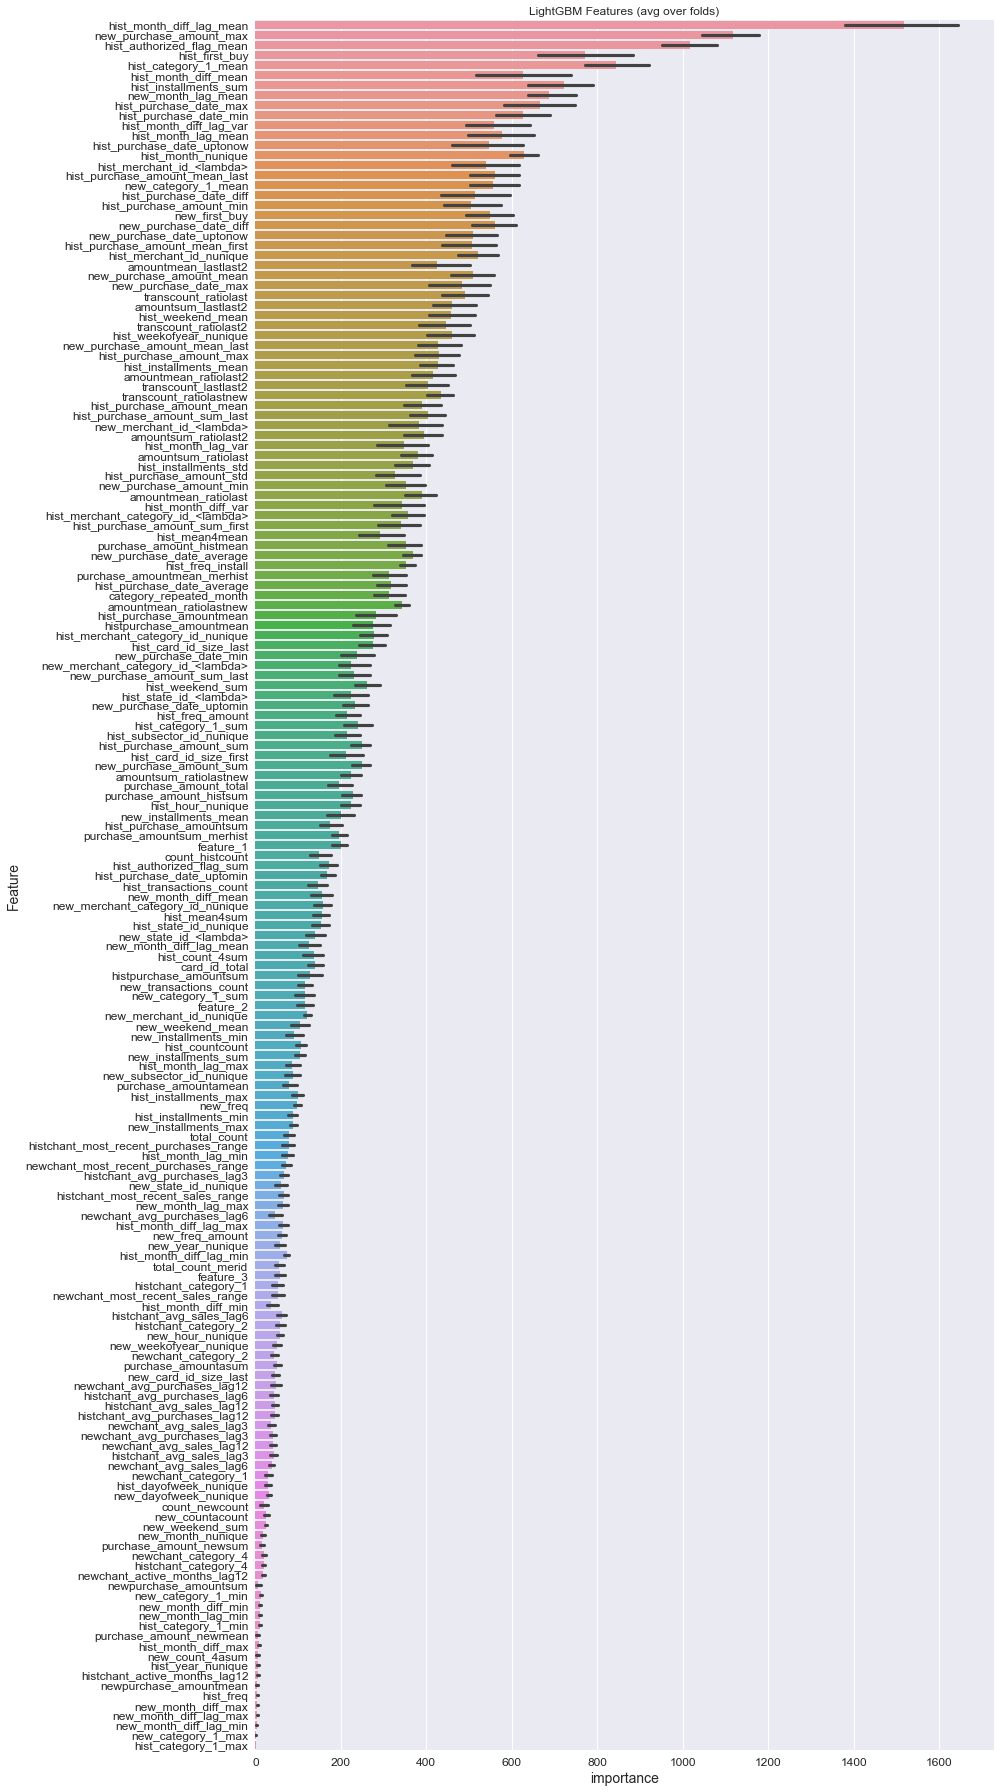

In [167]:
cols = (feature_importance_df[["Feature", "importance"]].groupby("Feature").mean()
        .sort_values(by="importance", ascending=False)[:1000].index)

best_features = feature_importance_df.loc[feature_importance_df.Feature.isin(cols)]

plt.figure(figsize=(14,25))
sns.barplot(x="importance",y="Feature",data=best_features.sort_values(by="importance",ascending=False))
plt.title('LightGBM Features (avg over folds)')
plt.tight_layout()

In [168]:
features = [c for c in train.columns if c not in ['card_id', 'first_active_month','target','outliers']]
cat_features = [c for c in features if 'feature_' in c]

In [169]:
param = {'num_leaves': 31,
         'min_data_in_leaf': 30, 
         'objective':'regression',
         'max_depth': -1,
         'learning_rate': 0.01,
         "min_child_samples": 20,
         "boosting": "gbdt",
         "feature_fraction": 0.9,
         "bagging_freq": 1,
         "bagging_fraction": 0.9 ,
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 0.1,
         "verbosity": -1,
         "nthread": 4,
         "random_state": 4590}

folds = RepeatedKFold(n_splits=6, n_repeats=2, random_state=4590)
oof_2 = np.zeros(len(train))
predictions_2 = np.zeros(len(test))
feature_importance_df_2 = pd.DataFrame()

for fold_, (trn_idx, val_idx) in enumerate(folds.split(train.values, target.values)):
    print("fold {}".format(fold_))
    trn_data = lgb.Dataset(train.iloc[trn_idx][features], label=target.iloc[trn_idx], categorical_feature=cat_features)
    val_data = lgb.Dataset(train.iloc[val_idx][features], label=target.iloc[val_idx], categorical_feature=cat_features)

    num_round = 10000
    clf_r = lgb.train(param, trn_data, num_round, valid_sets = [trn_data, val_data], verbose_eval=-1, early_stopping_rounds = 200)
    oof_2[val_idx] = clf_r.predict(train.iloc[val_idx][features], num_iteration=clf_r.best_iteration)
    
    fold_importance_df = pd.DataFrame()
    fold_importance_df["Feature"] = features
    fold_importance_df["importance"] = clf_r.feature_importance()
    fold_importance_df["fold"] = fold_ + 1
    feature_importance_df_2 = pd.concat([feature_importance_df_2, fold_importance_df], axis=0)
    
    predictions_2 += clf_r.predict(test[features], num_iteration=clf_r.best_iteration) / (6 * 2)

print("CV score: {:<8.5f}".format(mean_squared_error(oof_2, target)**0.5)) #64874

fold 0
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[782]	training's rmse: 3.36577	valid_1's rmse: 3.76323
fold 1
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[1953]	training's rmse: 3.19511	valid_1's rmse: 3.65733
fold 2
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[1274]	training's rmse: 3.31536	valid_1's rmse: 3.56682
fold 3
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[1458]	training's rmse: 3.26102	valid_1's rmse: 3.66046
fold 4
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[1234]	training's rmse: 3.30361	valid_1's rmse: 3.64054
fold 5
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[1526]	training's rmse: 3.26117	valid_1's rmse: 3.63402
fold 6
Training until validation sc

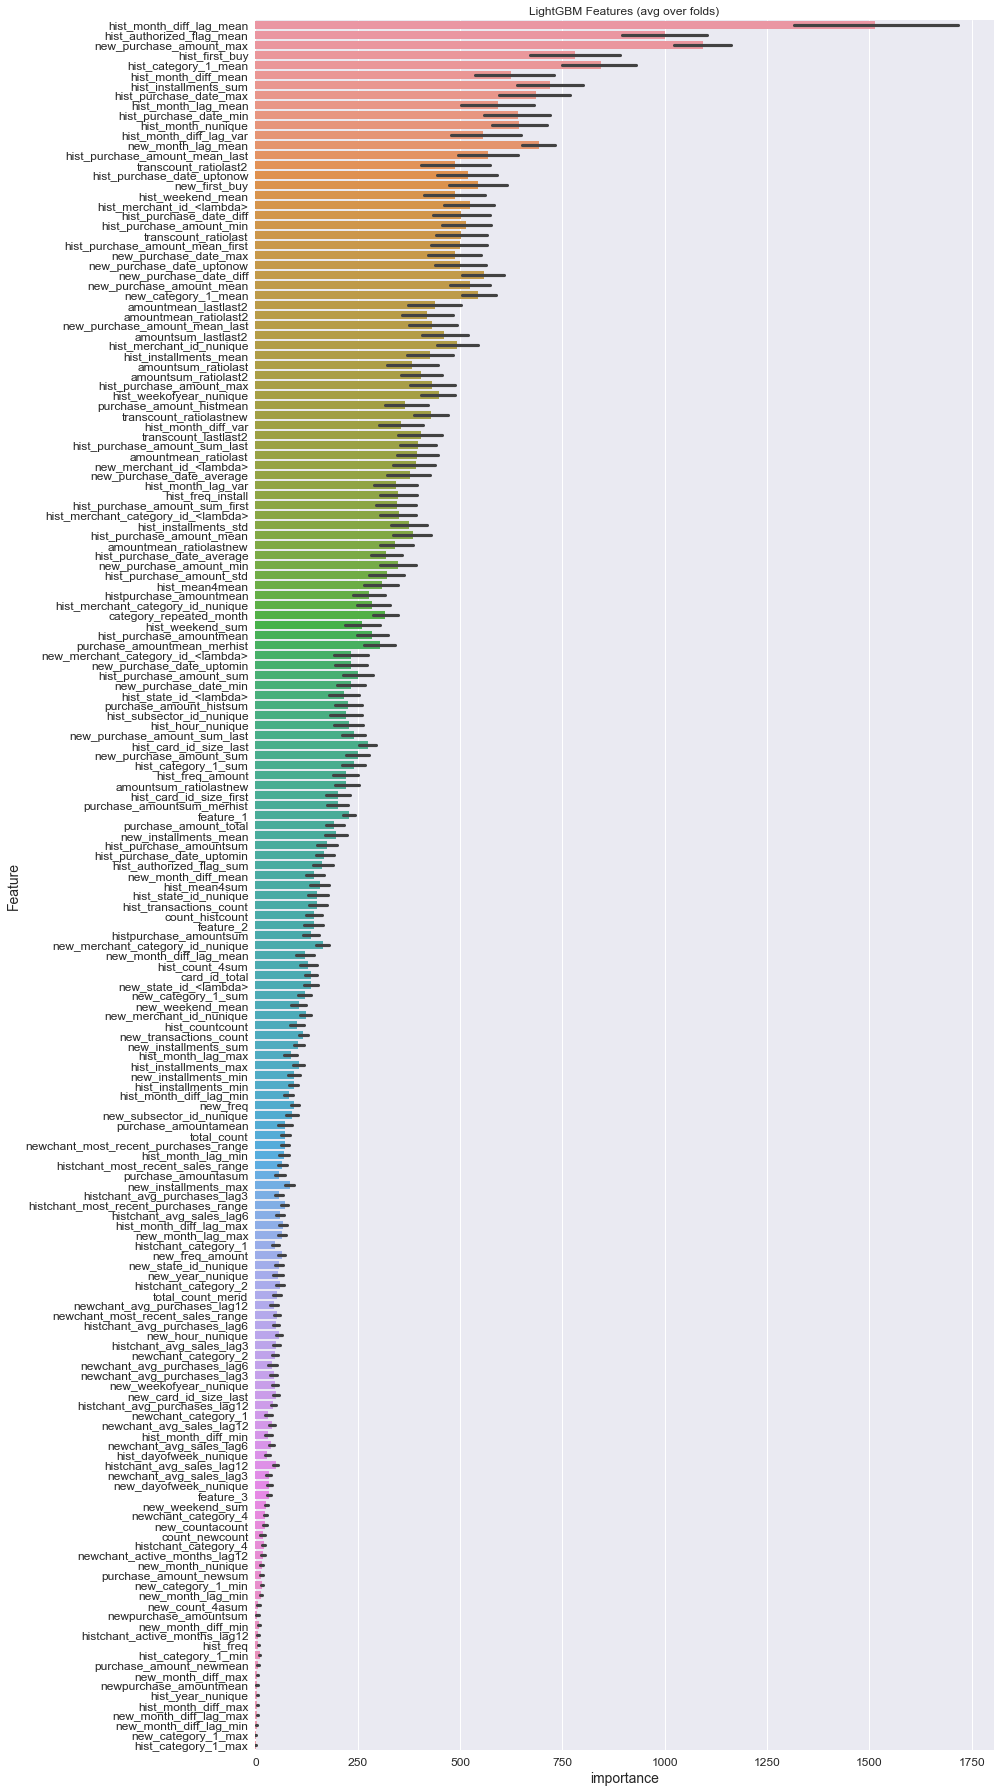

In [170]:
cols = (feature_importance_df_2[["Feature", "importance"]].groupby("Feature").mean()
        .sort_values(by="importance", ascending=False)[:1000].index)

best_features = feature_importance_df_2.loc[feature_importance_df_2.Feature.isin(cols)]

plt.figure(figsize=(14,25))
sns.barplot(x="importance",y="Feature",data=best_features.sort_values(by="importance",ascending=False))
plt.title('LightGBM Features (avg over folds)')
plt.tight_layout()

In [171]:
from sklearn.linear_model import BayesianRidge

train_stack = np.vstack([oof,oof_2]).transpose()
test_stack = np.vstack([predictions, predictions_2]).transpose()

folds_stack = RepeatedKFold(n_splits=6, n_repeats=1, random_state=4590)
oof_stack = np.zeros(train_stack.shape[0])
predictions_3 = np.zeros(test_stack.shape[0])

for fold_, (trn_idx, val_idx) in enumerate(folds_stack.split(train_stack,target)):
    print("fold {}".format(fold_))
    trn_data, trn_y = train_stack[trn_idx], target.iloc[trn_idx].values
    val_data, val_y = train_stack[val_idx], target.iloc[val_idx].values
    
    clf_3 = BayesianRidge()
    clf_3.fit(trn_data, trn_y)
    
    oof_stack[val_idx] = clf_3.predict(val_data)
    predictions_3 += clf_3.predict(test_stack) / 6
    
np.sqrt(mean_squared_error(target.values, oof_stack)) # 647227

fold 0
fold 1
fold 2
fold 3
fold 4
fold 5


3.649221649063096

In [ ]:
import re
regex = re.compile(r"\[|\]|<", re.IGNORECASE)
train.columns = [regex.sub("_", col) if any(x in str(col) for x in set(('[', ']', '<'))) else col for col in train.columns.values]
test.columns = [regex.sub("_", col) if any(x in str(col) for x in set(('[', ']', '<'))) else col for col in test.columns.values]
import xgboost as xgb
xgb_params = {'eta': 0.005, 'max_depth': 10, 'subsample': 0.8, 'colsample_bytree': 0.8, 
          'objective': 'reg:linear', 'eval_metric': 'rmse', 'silent': True}

folds = StratifiedKFold(n_splits=6, shuffle=True, random_state=15)
oof_xgb_3 = np.zeros(len(train))
predictions_xgb_3 = np.zeros(len(test))

train_columns = [regex.sub("_", col) if any(x in str(col) for x in set(('[', ']', '<'))) else col for col in df_train_columns]

for fold_, (trn_idx, val_idx) in enumerate(folds.split(train,train['outliers'].values)):    
    print('-')
    print("Fold {}".format(fold_))
    trn_data = xgb.DMatrix(data=train.iloc[trn_idx][train_columns], label=target.iloc[trn_idx])
    val_data = xgb.DMatrix(data=train.iloc[val_idx][train_columns], label=target.iloc[val_idx])
    watchlist = [(trn_data, 'train'), (val_data, 'valid')]
    print("xgb " + str(fold_) + "-" * 50)
    num_round = 10000
    xgb_model = xgb.train(xgb_params, trn_data, num_round, watchlist, early_stopping_rounds=50, verbose_eval=1000)
    oof_xgb_3[val_idx] = xgb_model.predict(xgb.DMatrix(train.iloc[val_idx][train_columns]), ntree_limit=xgb_model.best_ntree_limit+50)

    predictions_xgb_3 += xgb_model.predict(xgb.DMatrix(test[train_columns]), ntree_limit=xgb_model.best_ntree_limit+50) / folds.n_splits
    
np.sqrt(mean_squared_error(target.values, oof_xgb_3))

In [ ]:
train_stack = np.vstack([oof, oof_2, oof_xgb_3]).transpose()
test_stack = np.vstack([predictions, predictions_2, predictions_xgb_3]).transpose()

folds = StratifiedKFold(n_splits=6, shuffle=True, random_state=15)
oof = np.zeros(train_stack.shape[0])
predictions_x = np.zeros(test_stack.shape[0])

for fold_, (trn_idx, val_idx) in enumerate(folds.split(train_stack, train['outliers'].values)):
    print("fold n°{}".format(fold_))
    trn_data, trn_y = train_stack[trn_idx], target.iloc[trn_idx].values
    val_data, val_y = train_stack[val_idx], target.iloc[val_idx].values

    clf = BayesianRidge()
    clf.fit(trn_data, trn_y)
    
    oof[val_idx] = clf.predict(val_data)
    predictions_x += clf.predict(test_stack) / folds.n_splits


np.sqrt(mean_squared_error(target.values, oof))

In [ ]:
train.to_csv('mytrain.csv')
test.to_csv('mytest.csv')

In [99]:
sample_submission = pd.read_csv('sample_submission.csv')
sample_submission['target'] = predictions_3
# combine = pd.read_csv('combining_submission.csv')
# sample_submission['target'] = predictions_3*0.7 + combine['target']*0.3
q = sample_submission['target'].quantile(0.004)
# sample_submission['target'] = sample_submission['target'].apply(lambda x: x if x > q else x*1.1)
# sample_submission.loc[sample_submission.target < -19.8, 'target'] = -33.218750
# for i in [2726,17430,28039,42686,85003,108111]:
#     sample_submission['target'][i] = -33.21875
sample_submission.to_csv('submission.csv', index=False)

In [ ]:
((sample_submission.target <= -30) & (sample_submission.target > -35)).sum()

In [ ]:
sample_submission.iloc[108111]

In [100]:
q

-8.126377343349752

In [101]:
sample_submission.loc[sample_submission.target < -17]

,card_id,target
5008,C_ID_be92f84f5c,-21.173382
17720,C_ID_938dec7a1a,-18.787517
20556,C_ID_aae50409e7,-20.543496
25568,C_ID_767923bdb9,-18.331796
26864,C_ID_e7c702e96f,-19.710557
27436,C_ID_493de71141,-18.563287
27982,C_ID_e7f772dfc0,-17.004385
32446,C_ID_ac114ef831,-20.181368
35851,C_ID_5ee52cf9f6,-18.777012
37421,C_ID_366bf4ea4d,-19.634263


In [102]:
sample_submission.head(5)

,card_id,target
0,C_ID_0ab67a22ab,-2.912415
1,C_ID_130fd0cbdd,-0.261876
2,C_ID_b709037bc5,-0.979148
3,C_ID_d27d835a9f,-0.031344
4,C_ID_2b5e3df5c2,-1.357970


In [ ]:
my = pd.read_csv('submission (1).csv')
my['target'][117101] = -33.218750
my.to_csv('submission117101.csv', index=False)

## Classification

In [216]:
import itertools
import matplotlib.gridspec as gridspec
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, ExtraTreesClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.model_selection import KFold, cross_val_score, train_test_split, GridSearchCV, StratifiedKFold
from sklearn.metrics import mean_squared_error, accuracy_score, roc_curve, auc
from sklearn.preprocessing import LabelEncoder
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.neural_network import MLPClassifier
from xgboost.sklearn  import XGBClassifier
from mlxtend.classifier import StackingClassifier
from mlxtend.plotting import plot_decision_regions

In [66]:
y_train = train['outliers']
del train['outliers']

In [297]:
train = train.drop(['target'],axis = 1)
test = test.drop(['target'],axis = 1)

In [290]:
train['target'] = target
test['target'] = predictions_3

In [68]:
clf1 = ExtraTreesClassifier(n_estimators= 500,
                             max_features= 'auto',
                             criterion= 'entropy',
                             min_samples_split= 2,
                             max_depth= 14,
                             min_samples_leaf= 1, 
                             class_weight='balanced_subsample',
                             random_state=132,
                             verbose=0,
                             n_jobs = -1)

cv = StratifiedKFold(n_splits=5, random_state=123, shuffle=True)
outcomes = []
    
for (x, y), i in zip(cv.split(train, y_train), range(5)):
    Xtrain, Xtest = train.values[x], train.values[y]
    ytrain, ytest = y_train.values[x], y_train.values[y]
    clf1.fit(train.iloc[x], y_train.iloc[x]) 
    predictions = clf1.predict(Xtest)
    accuracy = accuracy_score(ytest, predictions)
    outcomes.append(accuracy)

pred1 = clf1.predict(test)
mean_outcome = np.mean(outcomes)
print("Mean Accuracy: {0}".format(mean_outcome)) 

Mean Accuracy: 0.9994106502053457


In [70]:
clf2 = ExtraTreesClassifier(n_estimators=500,
                             max_features= 'auto',
                             criterion= 'entropy',
                             min_samples_split= 3,
                             max_depth= 15,
                             min_samples_leaf= 3, 
                             class_weight='balanced_subsample',
                             random_state=1,
                             verbose=0,
                             n_jobs = -1)

cv = StratifiedKFold(n_splits=5, random_state=123, shuffle=True)
outcome = []
    
for (x, y), i in zip(cv.split(train, y_train), range(5)):    
    Xtrain, Xtest = train.values[x], train.values[y]
    ytrain, ytest = y_train.values[x], y_train.values[y]
    clf2.fit(train.iloc[x], y_train.iloc[x]) 
    predictions = clf2.predict(Xtest)
    accuracy = accuracy_score(ytest, predictions)
    outcomes.append(accuracy)

pred2 = clf2.predict(test)
mean_outcome = np.mean(outcomes)
print("Mean Accuracy: {0}".format(mean_outcome))

Mean Accuracy: 0.9993611247827017


In [157]:
clf4 = RandomForestClassifier(
    n_estimators=500,
    criterion='gini',
    max_depth= 7,
    min_samples_split=5,
    min_samples_leaf=5,
    min_weight_fraction_leaf=0.0,
    max_features=15,
    max_leaf_nodes=None,
    min_impurity_decrease=0.0,
    min_impurity_split=None,
    bootstrap=True,
    oob_score=False,
    n_jobs=-1,
    random_state=123,
    verbose=0,
    warm_start=False,
    class_weight='balanced')

cv = StratifiedKFold(n_splits=5, random_state=123, shuffle=True)
outcomes = []
    
for (x, y), i in zip(cv.split(train, y_train), range(5)):
    Xtrain, Xtest = train.values[x], train.values[y]
    ytrain, ytest = y_train.values[x], y_train.values[y]
    clf4.fit(train.iloc[x], y_train.iloc[x]) 
    predictions = clf4.predict(Xtest)
    accuracy = accuracy_score(ytest, predictions)
    outcomes.append(accuracy)

pred4 = clf4.predict(test)
mean_outcome = np.mean(outcomes)
print("Mean Accuracy: {0}".format(mean_outcome)) 

Mean Accuracy: 0.9956318941950946


In [195]:
clf5 = AdaBoostClassifier(base_estimator=clf1, 
                          n_estimators= 50, 
                          learning_rate=0.1,
                          depth=3,
                          random_state = 0)

cv = StratifiedKFold(n_splits=5, random_state=123, shuffle=True)
outcomes = []
    
for (x, y), i in zip(cv.split(train, y_train), range(5)):
    Xtrain, Xtest = train.values[x], train.values[y]
    ytrain, ytest = y_train.values[x], y_train.values[y]
    clf5.fit(train.iloc[x], y_train.iloc[x]) 
    predictions = clf5.predict(Xtest)
    accuracy = accuracy_score(ytest, predictions)
    outcomes.append(accuracy)

pred5 = clf5.predict(test)
mean_outcome = np.mean(outcomes)
print("Mean Accuracy: {0}".format(mean_outcome)) 

Mean Accuracy: 0.9994403645759444


In [291]:
sclf_target = StackingClassifier(classifiers=[clf1, clf4, clf5], 
                          meta_classifier=XGBClassifier(random_state = 1))
sclf_target.fit(train, y_train)
y_pred_target = sclf_target.predict(test)

In [308]:
clf3 = ExtraTreesClassifier(n_estimators=500,
                             max_features= 'auto',
                             criterion= 'entropy',
                             min_samples_split= 3,
                             max_depth= 28,
                             min_samples_leaf= 3, 
                             class_weight='balanced_subsample',
                             random_state=1,
                             verbose=0,
                             n_jobs = -1)

cv = StratifiedKFold(n_splits=5, random_state=123, shuffle=True)
outcome = []
    
for (x, y), i in zip(cv.split(train, y_train), range(5)):    
    Xtrain, Xtest = train.values[x], train.values[y]
    ytrain, ytest = y_train.values[x], y_train.values[y]
    clf3.fit(train.iloc[x], y_train.iloc[x]) 
    predictions = clf3.predict(Xtest)
    accuracy = accuracy_score(ytest, predictions)
    outcomes.append(accuracy)

pred3 = clf3.predict(test)
mean_outcome = np.mean(outcomes)
print("Mean Accuracy: {0}".format(mean_outcome))

Mean Accuracy: 0.9826933874323126


In [326]:
clf7 = RandomForestClassifier(
    n_estimators=500,
    criterion='gini',
    max_depth= 60,
    min_samples_split=2,
    min_samples_leaf=2,
    min_weight_fraction_leaf=0.0,
    max_features=15,
    max_leaf_nodes=None,
    min_impurity_decrease=0.0,
    min_impurity_split=None,
    bootstrap=True,
    oob_score=False,
    n_jobs=-1,
    random_state=123,
    verbose=0,
    warm_start=False,
    class_weight='balanced')

cv = StratifiedKFold(n_splits=5, random_state=123, shuffle=True)
outcomes = []
    
for (x, y), i in zip(cv.split(train, y_train), range(5)):
    Xtrain, Xtest = train.values[x], train.values[y]
    ytrain, ytest = y_train.values[x], y_train.values[y]
    clf7.fit(train.iloc[x], y_train.iloc[x]) 
    predictions = clf7.predict(Xtest)
    accuracy = accuracy_score(ytest, predictions)
    outcomes.append(accuracy)

pred7 = clf7.predict(test)
mean_outcome = np.mean(outcomes)
print("Mean Accuracy: {0}".format(mean_outcome)) 

Mean Accuracy: 0.988242693827442


In [335]:
import re
regex = re.compile(r"\[|\]|<", re.IGNORECASE)
train.columns = [regex.sub("_", col) if any(x in str(col) for x in set(('[', ']', '<'))) else col for col in train.columns.values]
test.columns = [regex.sub("_", col) if any(x in str(col) for x in set(('[', ']', '<'))) else col for col in test.columns.values]
test = test[train.columns]

clf6 = XGBClassifier(learning_rate =0.1,
                     n_estimators=300,
                     max_depth = 8,
                     min_child_weight=3,
                     gamma=0,
                     subsample=0.8,
                     colsample_bytree=0.8,
                     objective= 'binary:logistic',
                     nthread=4,
                     scale_pos_weight=1,
                     seed=13)
cv = StratifiedKFold(n_splits=5, random_state=123, shuffle=True)
outcome = []
    
for (x, y), i in zip(cv.split(train, y_train), range(5)):
    Xtrain, Xtest = train.values[x], train.values[y]
    ytrain, ytest = y_train.values[x], y_train.values[y]
    clf6.fit(train.iloc[x], y_train.iloc[x])
    predictions = clf6.predict(train.iloc[y])
    accuracy = accuracy_score(ytest, predictions)
    outcomes.append(accuracy)

pred6 = clf6.predict(test)
mean_outcome = np.mean(outcomes)
print("Mean Accuracy: {0}".format(mean_outcome))

Mean Accuracy: 0.9886141337614489


In [338]:
pred = np.round((pred1 + pred2 + pred3 + pred4 + pred5 + pred6 + pred7)/7)

In [341]:
sclf_nontarget = StackingClassifier(classifiers=[clf3, clf6, clf7], 
                          meta_classifier=AdaBoostClassifier(random_state = 1))
sclf_nontarget.fit(train, y_train)
y_pred_nontarget = sclf_nontarget.predict(test)

In [ ]:
r_pred = np.zeros(123623)
for i in Rxbg1.x:
    r_pred[i-1] = 1

In [343]:
ensemble = np.round((pred + y_pred_target + y_pred_nontarget)/3)

In [233]:
ensemble = np.round((pred1 + pred2)/2 - 0.01)

In [337]:
(pred6 == 1).sum()

55

In [366]:
sample_submission['outliers'] = pred
sample_submission.loc[sample_submission['outliers'] == 1, 'target'] = -33.218750
sample_submission = sample_submission.drop(['outliers'], axis = 1)
sample_submission.to_csv('submission.csv', index=False)

In [370]:
sample_submission['outliers'] = pred
sample_submission.loc[(sample_submission['outliers'] == 1)]

,card_id,target,outliers
496,C_ID_a7d1cd6b7c,-33.21875,1.0
1772,C_ID_4299911620,-33.21875,1.0
2426,C_ID_c219067cd7,-33.21875,1.0
2726,C_ID_1edbae8171,-33.21875,1.0
3868,C_ID_12e5f92245,-33.21875,1.0
4191,C_ID_87b47c2ac5,-33.21875,1.0
4355,C_ID_92b8b5d387,-33.21875,1.0
4549,C_ID_7c9093a3ce,-33.21875,1.0
4618,C_ID_c21e877db3,-33.21875,1.0
5008,C_ID_be92f84f5c,-33.21875,1.0


In [ ]:
Rxbg1 = pd.read_csv('prediction.csv')
sample_submission['outliers'] = 0
for i in Rxbg1.x:
    sample_submission['outliers'][i-1] = 1
sample_submission.loc[sample_submission['outliers'] == 1]
# sample_submission.loc[sample_submission['outliers'] == 1, 'target'] = -33.218750
# sample_submission = sample_submission.drop(['outliers'], axis = 1)
# sample_submission.to_csv('submission.csv', index=False)

In [ ]:
sub1 = pd.read_csv('82.csv')
sub2 = pd.read_csv('82 (2).csv')

In [ ]:
sample_submission = pd.read_csv('sample_submission.csv')
sample_submission['target'] = sub1['target']*0.5 + sub2['target']*0.5
sample_submission.to_csv('submission.csv', index=False)